In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

/Users/kushcoshic/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


\begin{equation}
f(x) = (2\pi)^{-\frac{k}{2}}| \mathbf{\Sigma} |^{- \frac{1}{2}} e^{- \frac{1}{2}\ (x-\mu)\prime \ \mathbf{\Sigma}^{-1}\ (x-\mu )}\ \ , \ \ \ k\equiv dimension
\end{equation}

In [2]:
x_start = np.array([[0.,0.,0.],[-0.9,0.9,0.9],[-0.9,-0.9,0.9],[0.9,-0.9,-0.9],[0.9,0.9,-0.9]]) 

dimension = len(x_start[0])

# Multivariate Normal distribution
x0=np.matrix(x_start[0])
cov=np.matrix([[1.,3./5,0.4],[0.6,2.,0.3],[0.4,0.3,1.]])
det=np.linalg.det(cov)
inv=np.linalg.inv(cov)
k=dimension       # dimension
def f(x):
    x=np.ravel(x)
    x=np.matrix(x)
    return ((2*np.pi)**(-k/2.))*((det)**(-1/2))*np.exp(-(1./2)*(x-x0)*inv*(x-x0).T)
cov

matrix([[ 1. ,  0.6,  0.4],
        [ 0.6,  2. ,  0.3],
        [ 0.4,  0.3,  1. ]])

In [3]:
n_eff_list = []
mcmc_step_list = []
n_eff_list_y = []

#covv=covv_stepper
covv=cov
mean=dimension*[0.]

def stepper(x):
    x=np.ravel(x)
    dx = np.random.multivariate_normal(mean, covv, 1)
    return x+dx

#global f


#ev = np.array([[1.,0.],[0.,1.]])      # Basis vectors chosen for the 2-d space

n_eff_min = 1000           # effective number of samples
mcmc_step = 20000          # MCMC iterations step=size
R_max = 1.1               # maximum allowed value for R

In [4]:
def run_mcmc(f,x_start,stepper,n_eff_min,R_max,mcmc_step):
    n_effective = np.zeros(dimension)
    n_eff_min_list = np.zeros(dimension)
    acceptance_list=[]
    for i in range(dimension):
        n_eff_min_list[i] = n_eff_min
    R_max_list = np.zeros(dimension)
    for i in range(dimension):
        R_max_list[i] = R_max
    
    #n_effective_y = 0
    z=0
    R=0
    mcmc_step_remember = mcmc_step
    x_recorded = np.zeros((mcmc_step,dimension,len(x_start)))
    while np.any(np.array(n_effective)<n_eff_min_list) or np.any(R>R_max_list):
        # MCMC results stored in a 3-d array, 3rd dimension corresponding to every new chain
        if z==0:
            mcmc_step_0=0
            x_recorded = np.zeros((mcmc_step,dimension,len(x_start)))
        else:
            x_recorded_template = np.zeros((mcmc_step,dimension,len(x_start)))         # this if-else is used to store the already computed MCMC samples, before moving to further iterations (if n_eff condition not satisfied). This prevents unecessary wastage of computational power.
            x_recorded_template[:mcmc_step_0,:,:]=x_recorded[:,:,:]
            x_recorded = x_recorded_template
        for i in range(len(x_start)):
            x_current = x_start[i]
            acceptances = np.zeros(mcmc_step)
            for k in range(mcmc_step_0,mcmc_step):
                x_new = stepper(x_current)
                if np.random.uniform(0,1) < f(x_new)/f(x_current):
                    x_current = x_new
                    acceptances[k] = 1
                x_recorded[k,:,i] = x_current
            acceptance_list.append(1.0*acceptances.sum()/len(acceptances))
            #print 'For chain %d,'%(i),
            #print 'acceptance fraction = %f'%(1.0*acceptances.sum()/len(acceptances))

        # Warm up period (extracting only second half of the iterations)
        x_warmup = np.zeros((mcmc_step/2,dimension,len(x_start)))
        x_warmup[:,:,:] = x_recorded[mcmc_step/2:,:,:]
        #plt.plot(x_warmup[:,0,:],x_warmup[:,1,:],'.',color='b')

        # Splitting the chains
        x_result = np.zeros((mcmc_step/4,dimension,2*len(x_start)))
        x_result[:,:,0:len(x_start)] = x_warmup[0:mcmc_step/4,:,:]
        x_result[:,:,len(x_start):2*len(x_start)] = x_warmup[mcmc_step/4:mcmc_step/2,:,:]
        
        #global x_result

        n=mcmc_step/4.0     # number of iterations in each chain
        m=2.0*(len(x_start))    # number of chains

        # Assessing mixing using between and within sequence variances

        psi = []
        for i in range(dimension):
            psi.append(x_result[:,i,:])
        psi = np.array(psi)
        
        
        psi_dot_j_bar = []
        psi_dot_dot_bar = []
        B_term = []
        B = []
        s_j_square_term = []
        s_j_square = []
        W = []
        var_dagger = []
        R = []
        i_array = []
        psi_i_comma_j = []
        psi_i_minus_t_comma_j = []
        V0 = []
        rho0 = []
        rho_array_set = []
        t_array_set = []
        n_effective_list = []
        t_array = np.arange(int(n))
        sum_rho = 0
        sum_rho_list = []
        
        
        for d in range(dimension):
            psi_dot_j_bar.append((1/n)*np.sum(psi[d], axis=0))
            
            psi_dot_dot_bar.append((1/m)*np.sum(psi_dot_j_bar[d]))
            
            B_term.append(psi_dot_j_bar[d] - psi_dot_dot_bar[d])
            
            B.append((n/(m-1.0))*np.sum(B_term[d]**2))

            s_j_square_term.append(np.zeros((int(n),int(m))))
            for j in range(int(m)):
                s_j_square_term[d][:,j] = (psi[d][:,j] - psi_dot_j_bar[d][j])**2.0

            s_j_square.append((1.0/(n-1))*np.sum(s_j_square_term[d], axis=0))
            
            W.append((1.0/(m))*np.sum(s_j_square[d]))
            

            # variance
            var_dagger.append(((n-1)/(n))*W[d] + (1/n)*B[d])
            
            #var_dagger

            # potential scale reduction
            R.append(np.sqrt(var_dagger[d]/W[d]))
            
            #R
            # Variogram
            def V(t):
                psi_i_comma_j = psi[d][t+1-1:,:]
                
                psi_i_minus_t_comma_j = psi[d][0:int(n)-t,:]
                
                t=float(t)
                #V0.append((1/(m*(n-t)))*np.sum(np.sum((psi_i_comma_j[d] - psi_i_minus_t_comma_j[d])**2.0,axis=0)))
                return (1.0/(m*(n-t)))*np.sum(np.sum((psi_i_comma_j - psi_i_minus_t_comma_j)**2.0,axis=0))
            
            # autocorrelation
            def rho(t):
                #rho0.append(1-(V(t)[d]/(2.0*var_dagger[d])))
                return 1.0-(V(t)/(2.0*var_dagger[d]))
            

            rho_array=np.zeros(int(n))
            for t in range(int(n)):
                rho_array[t]= rho(int(t))
            rho_array_set.append(rho_array)

            for i in range(int(n)):
                check = rho(i) + rho(i+1)
                if check < 0:
                    break
            i
            # effective sample size
            n_effective[d]=(m*n)/(1+2.0*np.sum(rho_array[1:i]))
            #n_effective_list.append(n_effective)
        
        mcmc_step_0 = mcmc_step
        mcmc_step += mcmc_step_remember
        z += 1
        #global n_effective_list
    
    # Finally what we choose as the effective sample size
    n_effective_final = np.amin(n_effective)
    
    # no. of samples to be skipped everytime
    samples_skip = 1.0*x_result.shape[2]*x_result.shape[0]/n_effective_final
    samples_skip=np.ceil(samples_skip)
    
    # store the independent samples in samples_final
    if int(x_result.shape[0]/samples_skip)==x_result.shape[0]/samples_skip:
        samples_final = np.zeros(int((x_result.shape[0])/samples_skip),x_result.shape[1],x_result.shape[2])
    else:
        samples_final = np.zeros((int(np.ceil((x_result.shape[0])/samples_skip)),x_result.shape[1],x_result.shape[2]))
    #samples_final = np.zeros((np.floor(x_result.shape[0]/np.floor(samples_skip))+1,x_result.shape[1],x_result.shape[2]))

    samples_final[:,:,:] = x_result[0:x_result.shape[0]:samples_skip,:,:]
    
    # putting all points of different chains into 1 single array which can be referred to as the final array of samples
    samples = np.zeros((samples_final.shape[0]*samples_final.shape[2],dimension))
    for i in range(samples_final.shape[2]):
        samples[i*samples_final.shape[0]:(i+1)*samples_final.shape[0],:]=samples_final[:,:,i]
    
    return n_effective,R,z-1,x_recorded.shape,x_result.shape,x_result,samples_final,samples,acceptance_list,x_recorded


run = run_mcmc(f,x_start,stepper,n_eff_min,R_max,mcmc_step)

/Users/kushcoshic/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:159: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[ 0.0013462   0.0050523   0.01811406] [ 1.02811064  2.00203196  1.03430902]
2.25058735613


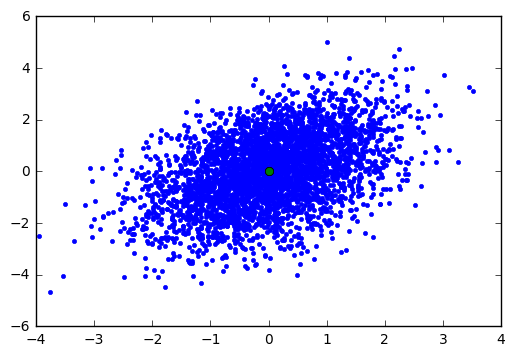

In [5]:
samples_final=run[6]

samples_final_mean = np.zeros(dimension)
samples_final_mean_variance = np.zeros(dimension)
for i in range(len(samples_final_mean)):
    samples_final_mean[i] = np.mean(samples_final[:,i,:])
    samples_final_mean_variance[i] = np.var(samples_final[:,i,:])
    
print samples_final_mean,samples_final_mean_variance
variance = (samples_final_mean_variance[0]**2.0 + samples_final_mean_variance[1]**2.0)**(1/2.0)
print variance

# Top view plot for effectively independent samples
plt.plot(samples_final[:,0,:],samples_final[:,1,:],'.',color='blue') 
plt.plot(samples_final_mean[0],samples_final_mean[1],'o',color='red')
plt.plot(0.,0.,'o',color='g')



[ 0.09817153 -0.02695057 -0.06330745] [ 1.01465538  2.12128665  0.9727194 ]
2.25058735613


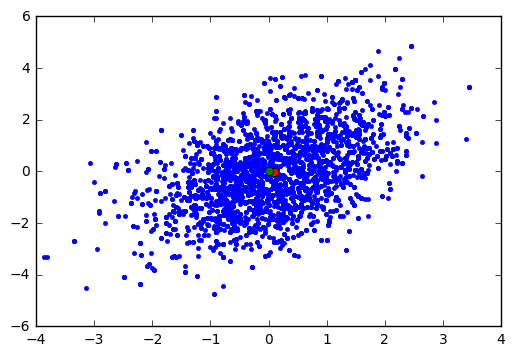

In [6]:
samples_final_1 = np.zeros((samples_final.shape[0],run[5].shape[1],run[5].shape[2]))

samples_final_1[:,:,:] = run[5][100:samples_final.shape[0]+100,:,:]

samples_final_mean1 = np.zeros(dimension)
samples_final_mean1_variance = np.zeros(dimension)
for i in range(len(samples_final_mean1)):
    samples_final_mean1[i] = np.mean(samples_final_1[:,i,:])
    samples_final_mean1_variance[i] = np.var(samples_final_1[:,i,:])
    
print samples_final_mean1,samples_final_mean1_variance
variance1 = (samples_final_mean1_variance[0]**2.0 + samples_final_mean1_variance[1]**2.0)**(1/2.0)
print variance

# Top view plot for effectively independent samples
plt.plot(samples_final_1[:,0,:],samples_final_1[:,1,:],'.',color='blue') 
plt.plot(samples_final_mean1[0],samples_final_mean1[1],'o',color='red')
plt.plot(0.,0.,'o',color='g')

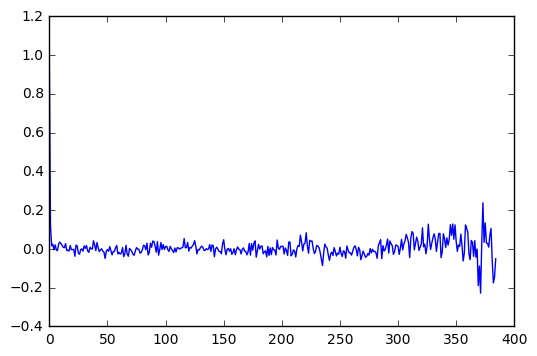

In [7]:
# # Calculating the autocorrelation in the uncorrelated final sample

n = samples_final.shape[0]*1.0
m = samples_final.shape[2]*1.0

sample_x = samples_final[:,0,:]
sample_y = samples_final[:,1,:]

def V(t):
    sample_x_i_comma_j = sample_x[t+1-1:,:]
    sample_x_i_minus_t_comma_j = sample_x[0:int(n)-t,:]
    t=float(t)
    return (1/(m*(n-t)))*np.sum(np.sum((sample_x_i_comma_j - sample_x_i_minus_t_comma_j)**2.0,axis=0))

def rho(t):
    return 1-(V(t)/(2.0*samples_final_mean_variance[0]))

rho_array = np.zeros(int(n))
t_array = np.arange(int(n))

for t in range(int(n)):
    rho_array[t]= rho(int(t))
    
plt.plot(t_array,rho_array,'-',color='b')

In [8]:
mu = np.mean(run[7],axis=0)
var = np.var(run[7],axis=0)
N = run[7].shape[0]
z = (mu-0)/np.sqrt(var/N)
print z

[ 0.08237994  0.22155642  1.1051497 ]


In [9]:
print samples_final_1.shape
samples_1 = np.zeros((samples_final_1.shape[0]*samples_final_1.shape[2],dimension))
for i in range(samples_final_1.shape[2]):
    samples_1[i*samples_final_1.shape[0]:(i+1)*samples_final_1.shape[0],:]=samples_final_1[:,:,i]
print samples_1.shape

mu_1 = np.mean(samples_1,axis=0)
var_1 = np.var(samples_1,axis=0)
N_1 = samples_1.shape[0]
z_1 = (mu-0)/np.sqrt(var_1/N_1)
print z_1

(385, 3, 10)
(3850, 3)
[ 0.08292436  0.2152386   1.1396001 ]


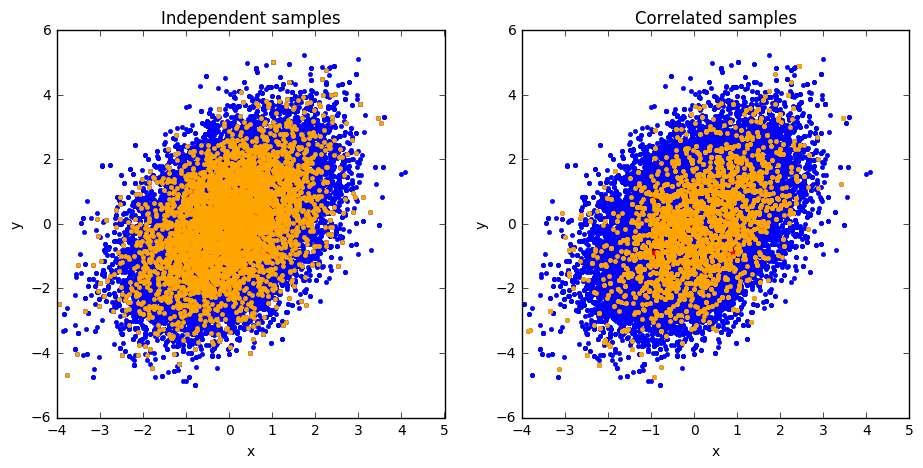

In [10]:
plt.figure(1,figsize=(11,5))
plt.subplot(1,2,1).set_title('Independent samples')
plt.plot(run[5][:,0,:],run[5][:,1,:],'.',color='b')
plt.plot(x_start[:,0],x_start[:,1],'or',color='r')
plt.plot(run[7][:,0],run[7][:,1],'.',color='orange')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,2,2).set_title('Correlated samples')
plt.plot(run[5][:,0,:],run[5][:,1,:],'.',color='b')
plt.plot(x_start[:,0],x_start[:,1],'or',color='r')
plt.plot(samples_1[:,0],samples_1[:,1],'.',color='orange')
plt.xlabel('x')
plt.ylabel('y')

In [11]:
run[7].shape

(3850, 3)

In [12]:
np.cov(run[7].T)

array([[ 1.02837775,  0.63866044,  0.41587406],
       [ 0.63866044,  2.0025521 ,  0.30886774],
       [ 0.41587406,  0.30886774,  1.03457774]])

In [13]:
covv

matrix([[ 1. ,  0.6,  0.4],
        [ 0.6,  2. ,  0.3],
        [ 0.4,  0.3,  1. ]])

In [14]:
np.cov(run[9][:,:,1].T)

array([[ 1.02463392,  0.60263485,  0.41608571],
       [ 0.60263485,  1.99608633,  0.2950663 ],
       [ 0.41608571,  0.2950663 ,  1.00771638]])

In [15]:
np.cov(run[5][:,:,1].T)

array([[ 1.09243366,  0.65455064,  0.46824052],
       [ 0.65455064,  2.0386998 ,  0.3192625 ],
       [ 0.46824052,  0.3192625 ,  1.01275985]])

In [16]:
np.cov(run[9][:,:,0].T)

array([[ 1.02528909,  0.64428687,  0.40300386],
       [ 0.64428687,  2.04127566,  0.32384831],
       [ 0.40300386,  0.32384831,  0.99461786]])

In [17]:
np.allclose(np.cov(run[7].T),cov,.06,.06)

True

In [18]:
np.linalg.det(np.cov(run[7].T)-covv)

-4.116709858274612e-05